<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block" display=block align=center>
        <img width=250 align=right  src="https://www.ucalgary.ca/sites/default/files/styles/ucws_image_desktop/public/2019-09/UCalgary_Vertical_logo_colour_1.jpg?h=55272f2a&itok=i9FNcCfH" style="margin:0;" />
    </div>
    <br>
    <div style="display:block" align=left display=block>
        <br>
        <font size=5><b>Final Project</b>: <br> DEEP LEARNING ARCHITECTURES EVALUATION FOR CLASSIFICATION OF MOSQUITO SPECIES ALONG WITH MODEL INTERPRETATION USING GRADCAM </font><br><br>
        <font size=4>Authors: </font><br>
        <font size=4><a href="mailto:sara.montajab@ucalgary.ca">Sara Montajab</a>, 30221523</font><br>
        <font size=4><a href="mailto:bita.asghari@ucalgary.ca">Bita Asghari</a>, 30225540</font><br><br>
        <font size=3>Date: April 7, 2024</font><br><br>
        <hr style="height:1px;border-width:0;color:black;background-color:black">
    </div>
</div>

## Table of Content
1. [Introduction](#intro)
1. [Set Up](#setup)
1. [Define Dataset](#dataset)
1. [Define Models](#models)
1. [Visualization Function](#visualize)     
1. [Train Models](#train)     
1. [Evalluate Models](#evaluate)     
1. [Grad-CAM](#gradcam)     
1. [Conclusion](#conclusion)     

<a id="intro"></a>
## Introduction

<div style="display:block" direction=rtl align=right>
  <div  style="width:100%;margin:100;display:block" display=block align=center>
        <img width=280 align=right src="https://images.unsplash.com/photo-1589628750285-3a22f8644b94?q=80&w=1935&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" style="margin:0;" />
  </div>
  <br>
  <div style="display:block" align=left display=block>
      <font size=3>Mosquitoes, known for spreading deadly diseases worldwide, are a global health challenge. The identification of mosquito species is crucial for controlling the spread of these diseases. Leveraging the advancements in deep learning, this study demonstrates that mosquito species can be accurately identified through images captured by standard cameras, bypassing the need for microscopic examination. Our evaluation focused on deep learning models, with a particular emphasis on the application of the Grad-CAM method to enhance model transparency. This approach not only achieved an impressive accuracy in classifying 650 mosquito images across five species (Aedes, Bandar, Chabahar, Kazeron, Culex) but also provided valuable visual insights into the decision-making processes of the models, shedding light on the distinguishing features used for species classification. This research marks a significant step forward in the use of machine learning for public health surveillance and mosquito-borne disease control.</font>
  </div>
</div>

<a id="setup"></a>
## Setup

### >> Mount Drive

We also need to mount our drive in order to use the MyDrive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### >> Import Libraries

Now we are going to import all the necessary libraries

In [2]:
import re
import time
import copy
import cv2
import os
from os import walk
import numpy as np
import pandas as pd
import matplotlib
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.utils import make_grid
from torch.utils.data  import Dataset,DataLoader
from torchvision import transforms,datasets, models

import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

Define some necessary parameters

In [3]:
batch_size = 32
num_epoch = 25

<a id="dataset"></a>
## Define Dataset

### >> Dataset

This is a custom dataset class for handling mosquito image datasets.

In [4]:
class Mosquito_dataset(Dataset):

    # Initialization method where dataset parameters are set up.
    def __init__(self,root_dir,transform=None):
        super(Mosquito_dataset,self).__init__()  # Call to the superclass' __init__ method.
        self.root_dir = root_dir  # Directory where the dataset is stored.
        self.transform = transform  # Transformations to apply to the images.
        self.classes = {'Aedes':0, 'bandar':1, 'chabahar':2, 'kazeron':3, 'culex':4}  # Mapping of class names to numeric labels.
        self.filenames = []  # List to store file paths of images.
        self.labels = []  # List to store corresponding labels for images.

        # Loop through each directory in the root directory, each representing a class.
        for dirname in os.listdir(root_dir):
            class_add = os.path.join(root_dir, dirname)  # Get the full path to the class directory.
            # Loop through each file in the class directory and add its path and label to the respective lists.
            for file in os.listdir(class_add):
                self.filenames.append(os.path.join(class_add, file))  # Add file path to the filenames list.
                self.labels.append(self.classes[dirname])  # Add corresponding label to the labels list.

    # Method to get the total count of data samples in the dataset.
    def __len__(self):
        return len(self.filenames)  # Return the total number of filenames, which is the dataset size.

    # Method to get a single data sample and its label by index.
    def __getitem__(self,idx):
        img = Image.open(self.filenames[idx])  # Open the image file at the specified index.

        # If a transform is specified, apply it to the image.
        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]  # Return the possibly transformed image and its label.


### >> Data Transform

This code defines preprocessing steps for training and testing data. Training data undergoes extensive augmentation, including resizing, normalization, and random transformations to improve model robustness. Testing data is simply resized and normalized for consistency.

In [5]:
# This defines transformations to be applied to the dataset for both training and testing phases.
data_transforms = {
    'Train': transforms.Compose([
        # Collection of transformations for the training dataset.
        transforms.Resize((224,224)),  # Resize images to 224x224.
        transforms.ToTensor(),  # Convert images to Tensor.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize images with mean and std.
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally to augment the dataset.
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically for further augmentation.
        transforms.RandomRotation(45),  # Randomly rotate images up to 45 degrees for diversity.
        transforms.RandomResizedCrop(224),  # Randomly crop and resize images to 224x224 for variability.
    ]),

    'Test': transforms.Compose([
        # Collection of transformations for the testing dataset.
        transforms.Resize((224,224)),  # Resize images to 224x224, matching the training phase.
        transforms.ToTensor(),  # Convert images to Tensor, consistent with the training phase.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images as in training.
    ]),
}

### >> Data Augmentation and DataLoader Setup


This code sets up the structure for handling mosquito classification data. It specifies the directory for training and testing data, initializes dataset objects with transformations, and creates dataloaders for efficient batch processing. Additionally, it calculates dataset sizes for monitoring and extracts class names for output interpretation. This setup is essential for training and evaluating the model effectively.

In [6]:
# Paths and dataset preparations for training and testing phases.
data_dir = '/content/drive/MyDrive/mosquito-classification'

# Creating dataset objects for both training and testing sets using the custom Mosquito_dataset class.
image_datasets = {
    x: Mosquito_dataset(os.path.join(data_dir, x), data_transforms[x])  # Apply appropriate transformations.
    for x in ['Train','Test']  # Separate datasets for training and testing.
}

# Setting up dataloaders to efficiently load data during training and testing, with specific configurations for each phase.
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],  # Dataset to load.
        batch_size=batch_size,  # Size of each batch of data.
        shuffle=True if x == 'Train' else False,  # Only shuffle data during training for randomness.
        num_workers=0  # Number of subprocesses to use for data loading (0 means that the data will be loaded in the main process).
    )
    for x in ['Train','Test']  # Separate dataloaders for training and testing.
}

# Calculating the sizes of both datasets to keep track of the number of samples in each.
dataset_sizes = {
    x: len(image_datasets[x])  # Get the size of each dataset.
    for x in ['Train','Test']  # Sizes for both training and testing datasets.
}

# Extracting the class names from the training dataset to use later (e.g., for labeling purposes).
class_names = image_datasets['Train'].classes  # Classes are the same for both training and testing datasets.

Device configuration for PyTorch operations to utilize GPU acceleration if available.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Checks for GPU availability and sets the device accordingly.

Displaying the number of samples in the training and testing datasets to provide insights into dataset size.

In [8]:
# Prints out the total number of samples in the training dataset.
print(f"Number of training samples are: {len(image_datasets['Train'])}")

# Prints out the total number of samples in the testing dataset.
print(f"Number of testing samples are: {len(image_datasets['Test'])}")

Number of training samples are: 600
Number of testing samples are: 49


### >> Image Visualization

A function for visualizing images from a DataLoader, useful for inspecting the dataset and transformations.

In [9]:
def imshow(dl, nrows, ncols):
    """Imshow for Tensor."""
    # Set up a figure with a grid of subplots.
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    axs = axs.ravel()  # Flatten the array of axes to iterate over them in a loop.

    count = 0  # Counter to keep track of the number of images processed.
    # A list of class names corresponding to the labels.
    class_names = ['aedss', 'bandarabbas', 'chabaharr', 'kazeronn', 'culexx']

    for inputs, classes in dl:  # Iterate over batches of data (images and labels).

        for image, label in zip(inputs, classes):  # Iterate over images and labels in the current batch.

            inp = image.numpy().transpose((1, 2, 0))  # Convert the tensor image to a NumPy array and fix the channel order.
            mean = np.array([0.485, 0.456, 0.406])  # Mean for un-normalization.
            std = np.array([0.229, 0.224, 0.225])  # Standard deviation for un-normalization.
            inp = std * inp + mean  # Un-normalize the image.
            inp = np.clip(inp, 0, 1)  # Clip values to [0, 1] to avoid display errors.
            axs[count].imshow(inp)  # Display the image on the corresponding subplot.
            axs[count].set_title(class_names[label])  # Set the title of the subplot to the corresponding class name.
            axs[count].axis('off')  # Remove axes for a cleaner look.

            count += 1  # Increment the image counter.

            if count == nrows * ncols:  # Check if the desired number of images have been processed.
                return  # Exit the function once the grid is filled.

Displaying a grid of images from the training dataset to visually inspect the data and its augmentations.

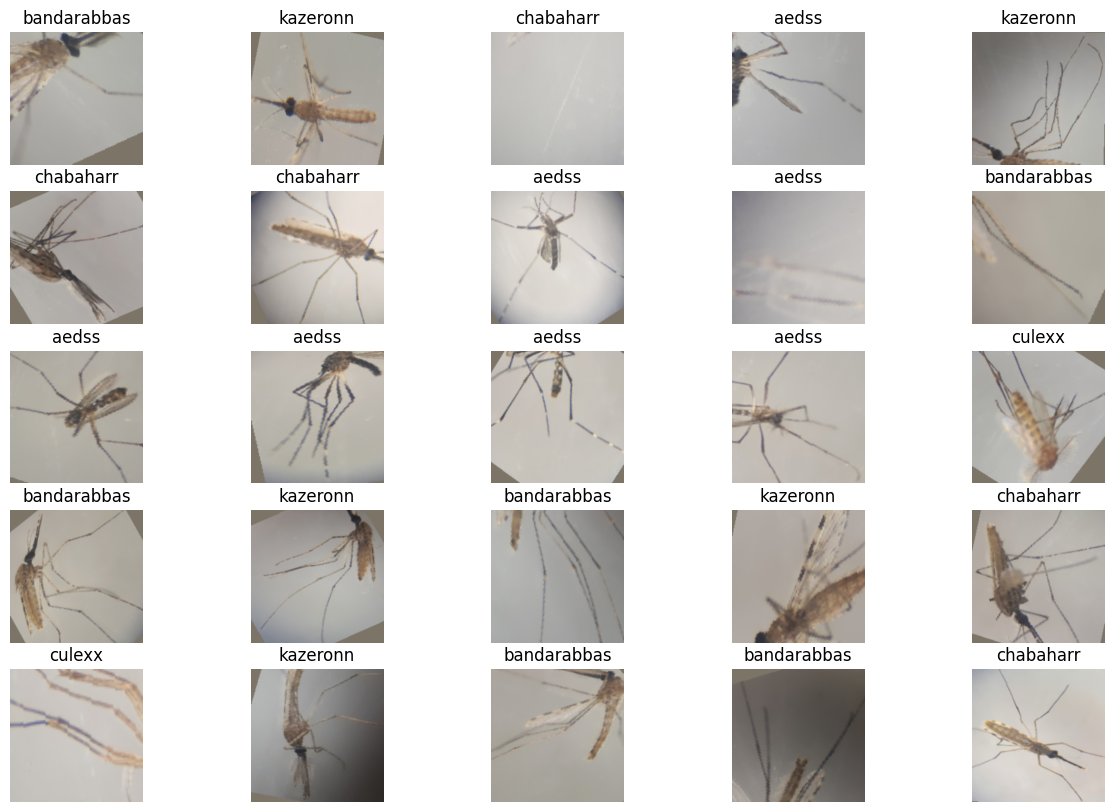

In [10]:
# This visualizes how the images and their augmentations appear to the model during training.
imshow(dataloaders['Train'], nrows=5, ncols=5)  # Specifies a 5x5 grid for visualization.

<a id="models"></a>
## Define Models

### >> Train Model

This function trains a model, alternating between training and validation phases, and tracks performance metrics. It resumes from checkpoints if available, adjusts learning rates, and visualizes losses, saving the best model state for future use.

In [11]:
# This function is for training a model with given parameters and architecture, including checkpointing and visualization.
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=25):
    # Determine and announce the computation mode based on CUDA availability.
    if torch.cuda.is_available():
        print('--------- Training in Cuda Mode ----------')
    else:
        print('--------- Training in Cpu Mode ----------')

    # Check for an existing checkpoint to resume training from.
    if os.path.exists('checkpoint.tar'):
        checkpoint = torch.load('checkpoint.tar')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        last_epoch = checkpoint['epoch']
        last_time_elapsed = checkpoint['time']
        best_acc = checkpoint['best_acc']
        losses = checkpoint['losses']
    else:  # Initialize parameters if no checkpoint is found.
        last_epoch = 0
        last_time_elapsed = 0
        best_acc = 0.0
        losses = {'Train': [], 'Test': []}

    since = time.time()  # Start timing the training process.

    best_model_wts = copy.deepcopy(model.state_dict())  # Keep track of the best model weights.

    for epoch in range(last_epoch, num_epochs):  # Loop over the dataset multiple times.
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch consists of a training phase and a validation (test) phase.
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                scheduler.step()  # Adjust the learning rate based on the epoch.
                model.train()  # Set the model to training mode.
            else:
                model.eval()  # Set the model to evaluation mode for testing.

            running_loss = 0.0
            running_corrects = 0

            # Iterate over the data for the current phase.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # Zero the parameter gradients.

                # Forward pass. Track history if in train phase.
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase.
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            losses[phase].append(epoch_loss)  # Record the loss for this epoch.

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Update the best model if this is the highest accuracy to date.
            if phase == 'Test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since + last_time_elapsed  # Total training time.
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Visualization of training and validation losses.
    plt.plot(losses['Train'], label='Training loss')
    plt.plot(losses['Test'], label='Validation loss')
    idx = np.argmin(losses['Test'])
    plt.plot([idx, idx], [0, losses['Test'][idx]], '--', color='coral', label='Best')
    plt.plot([0, idx], [losses['Test'][idx], losses['Test'][idx]], '--', color='coral')
    plt.plot(idx, losses['Test'][idx], 'o', color='coral', markersize=8, markerfacecolor="None")
    plt.legend()
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.tight_layout()
    plt.title(f'{model_name} Train-Test loss', fontsize=12)
    plt.savefig(f'loss_{model_name}.png', bbox_inches='tight')
    plt.show()

    # Load the best model weights found during training.
    model.load_state_dict(best_model_wts)
    return model


### >> Test Model

This function evaluates a model's performance on a given dataset, providing the true labels and predictions. It starts by setting the computation mode based on CUDA availability, switches the model to evaluation mode, and iterates over the dataset to collect predictions and actual labels without gradient computation for efficiency. The process is timed, and the function concludes by returning the gathered true labels and predictions, along with the total evaluation time.

In [12]:
# This function evaluates the model on a given dataset and returns the true labels and predictions.

def test_model(model, dataloader):
    # Determine and announce the computation mode based on CUDA availability.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print('--------- Cuda Mode ----------')
    else:
        print('--------- Cpu Mode ----------')

    print('Predicting...')  # Start the prediction phase.
    predictions = np.array([])  # Initialize an array to hold model predictions.
    targets = np.array([])  # Initialize an array to hold the true labels.

    model.eval()  # Set the model to evaluation mode.

    since = time.time()  # Start timing the prediction process.

    # Iterate over the data in the provided dataloader.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)  # Move input data to the device.
        labels = labels.to(device)  # Move labels to the device.

        with torch.no_grad():  # Inference without calculating gradients.
            outputs = model(inputs)  # Get model outputs for the current batch.
            _, preds = torch.max(outputs, 1)  # Get the predicted labels.

        # Append current predictions and true labels to the respective arrays.
        predictions = np.append(predictions, preds.cpu().numpy())
        targets = np.append(targets, labels.cpu().numpy())

    print()

    time_elapsed = time.time() - since  # Calculate the total prediction time.
    # Print the duration of the prediction process.
    print(f'Testing completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return targets, predictions  # Return the true labels and model predictions.

<a id="visualize"></a>
## Define Visualization

### >> Misclassification Visualization

This function showcases misclassified images by the model, aiding in the visual assessment of its performance. Upon setting the model to evaluation mode, it iterates through the dataloader to identify and display misclassified instances within a specified subplot grid. For each misclassified image, it reverses normalization for display clarity and annotates the image with both the predicted and actual class labels. The process halts once the grid is filled, providing a focused view of the model's errors for further analysis and refinement.

In [13]:
# A function to display misclassified images from a dataloader, helping to visually diagnose model performance.

def show_misclass(model, dataloader, nrows, ncols):
    model.eval()  # Set the model to evaluation mode.
    images_so_far = 0  # Counter to track the number of images displayed.
    # Define class names for display.
    class_names = ['aedss', 'bandarabbas', 'chabaharr', 'kazeronn', 'culexx']
    # Set up a grid of subplots.
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    plt.subplots_adjust(hspace=0.3)  # Adjust the spacing between plots.
    axs = axs.ravel()  # Flatten the array of axes.

    # Iterate over the data in the dataloader.
    for inputs, labels in dataloader:
        with torch.no_grad():  # Perform inference without tracking gradients.
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # Get model outputs.
            _, preds = torch.max(outputs, 1)  # Determine predicted labels.

            # Identify indices of misclassified images.
            for i in torch.nonzero(preds != labels):
                image = inputs[i.item()].cpu()  # Extract the misclassified image.
                inp = image.numpy().transpose((1, 2, 0))  # Convert to NumPy array and correct the channel order.
                # Define mean and std for un-normalization.
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean  # Un-normalize the image.
                inp = np.clip(inp, 0, 1)  # Clip values to [0, 1] range.
                # Get predicted and true class indices.
                class_idx = preds[i].detach().cpu().item()
                true_class_idx = labels[i].detach().cpu().item()

                # Display the misclassified image with predicted and true labels.
                axs[images_so_far].imshow(inp)
                axs[images_so_far].set_title(f"Pred:{class_names[class_idx]} \n (True:{class_names[true_class_idx]})")
                axs[images_so_far].axis('off')
                images_so_far += 1

                if images_so_far == nrows * ncols:  # Check if the grid is full.
                    return  # Exit the function if the specified number of misclassifications have been displayed.


### >> Confusion Matrix Plot Function

This function plots a confusion matrix to assess a model's classification accuracy. It offers normalization and employs a color map for visual distinction. Class names label the axes, with text annotations indicating counts or percentages within cells, ensuring clarity and contrast for easy interpretation. This plot is key for identifying model strengths and weaknesses across categories.

In [14]:
# A function to plot a confusion matrix, useful for evaluating classification performance in a visual format.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # This function prints and plots the confusion matrix.
    plt.figure(figsize=(7, 5))  # Set the figure size for the plot.
    plt.imshow(cm, interpolation='nearest', cmap=cmap)  # Display the confusion matrix as an image.
    plt.title(title)  # Set the title of the plot.
    plt.colorbar()  # Add a color bar to indicate the scale.
    tick_marks = np.arange(len(classes))  # Define tick marks based on the number of classes.
    plt.xticks(tick_marks, classes, rotation=45)  # Set x-axis labels with class names, rotated for readability.
    plt.yticks(tick_marks, classes)  # Set y-axis labels with class names.

    if normalize:  # Check if normalization is requested.
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix.

    thresh = cm.max() / 2.  # Set a threshold for text color contrast.
    # Iterate over data to create text annotations within each cell of the matrix.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")  # Change text color for readability based on background.

    plt.tight_layout()  # Adjust layout to prevent clipping of labels.
    plt.ylabel('True label')  # Label for the y-axis.
    plt.xlabel('Predicted label')  # Label for the x-axis.

<a id="train"></a>
## Train Models

In [15]:
number_classes = 5

### >> DensNet121

DenseNet121 introduces dense connections between each layer to the subsequent layers, enhancing feature propagation and reuse, which leads to reduced model complexity and improved efficiency.



-----------------------------------------------------------
 	 DENSENET121 
----------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 105MB/s]


--------- Training in Cuda Mode ----------
Epoch 0/19
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Loss: 1.4747 Acc: 0.4233
Test Loss: 1.5820 Acc: 0.3469

Epoch 1/19
----------
Train Loss: 1.1493 Acc: 0.5667
Test Loss: 1.4387 Acc: 0.4898

Epoch 2/19
----------
Train Loss: 1.0001 Acc: 0.6333
Test Loss: 1.6010 Acc: 0.4082

Epoch 3/19
----------
Train Loss: 0.8356 Acc: 0.6817
Test Loss: 0.8743 Acc: 0.6327

Epoch 4/19
----------
Train Loss: 0.6673 Acc: 0.7517
Test Loss: 0.9384 Acc: 0.6735

Epoch 5/19
----------
Train Loss: 0.6608 Acc: 0.7417
Test Loss: 1.2069 Acc: 0.6531

Epoch 6/19
----------
Train Loss: 0.6391 Acc: 0.7583
Test Loss: 0.8031 Acc: 0.7143

Epoch 7/19
----------
Train Loss: 0.5998 Acc: 0.7767
Test Loss: 0.8250 Acc: 0.6735

Epoch 8/19
----------
Train Loss: 0.6056 Acc: 0.7567
Test Loss: 0.9356 Acc: 0.6735

Epoch 9/19
----------
Train Loss: 0.6031 Acc: 0.7717
Test Loss: 0.8895 Acc: 0.6735

Epoch 10/19
----------
Train Loss: 0.6101 Acc: 0.7800
Test Loss: 0.7152 Acc: 0.7347

Epoch 11/19
----------
Train Loss: 0.6131 Acc: 0.7567
Test Loss: 0.7914 Acc: 0.7143

Epoch 12/19


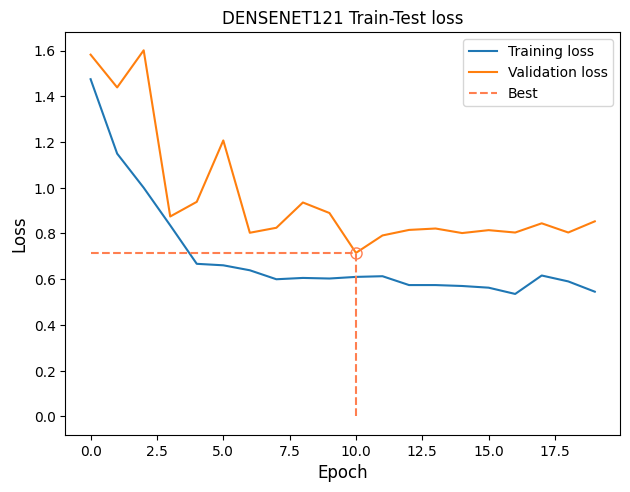

In [16]:
# Initializing and training a DENSENET121 model with the dataset.
print('-----------------------------------------------------------\n',
      '\t DENSENET121',
      '\n----------------------------------------------------------')

# Load a pre-trained DENSENET121 model.
model_dn = models.densenet121(pretrained=True)

# Freeze all the parameters in the model to prevent them from being updated during training.
for param in model_dn.parameters():
    param.requires_grad = False

# Retrieve the number of features in the classifier layer of the model.
num_ftrs = model_dn.classifier.in_features
# Replace the classifier layer with a new one, adjusted for the number of classes in our dataset.
model_dn.classifier = nn.Linear(num_ftrs, number_classes)

# Move the model to the appropriate device (GPU or CPU).
model_dn = model_dn.to(device)

# Define the loss function.
criterion = nn.CrossEntropyLoss()

# Define the optimizer. Here, we're using SGD with momentum.
optimizer_ft = optim.SGD(model_dn.parameters(), lr=0.01, momentum=0.9)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model with the specified parameters.
model_dn = train_model(model_dn, 'DENSENET121', criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

### >> ResNet18

ResNet18 utilizes residual connections to facilitate the training of deeper neural networks by directly connecting input from one layer to a later layer, helping to prevent the vanishing gradient problem.

-----------------------------------------------------------
 	 RESNET18 
----------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should c

--------- Training in Cuda Mode ----------
Epoch 0/19
----------
Train Loss: 1.6015 Acc: 0.3683
Test Loss: 2.2776 Acc: 0.2653

Epoch 1/19
----------
Train Loss: 1.0986 Acc: 0.5850
Test Loss: 0.8863 Acc: 0.6327

Epoch 2/19
----------
Train Loss: 1.2010 Acc: 0.5767
Test Loss: 1.2723 Acc: 0.6122

Epoch 3/19
----------
Train Loss: 0.8980 Acc: 0.6467
Test Loss: 1.4127 Acc: 0.6327

Epoch 4/19
----------
Train Loss: 0.8739 Acc: 0.6733
Test Loss: 1.0736 Acc: 0.7143

Epoch 5/19
----------
Train Loss: 0.7569 Acc: 0.7000
Test Loss: 1.6510 Acc: 0.6735

Epoch 6/19
----------
Train Loss: 0.6869 Acc: 0.7583
Test Loss: 0.9293 Acc: 0.6939

Epoch 7/19
----------
Train Loss: 0.6752 Acc: 0.7300
Test Loss: 1.0520 Acc: 0.6735

Epoch 8/19
----------
Train Loss: 0.6650 Acc: 0.7550
Test Loss: 0.9298 Acc: 0.6735

Epoch 9/19
----------
Train Loss: 0.5813 Acc: 0.7767
Test Loss: 0.9309 Acc: 0.6735

Epoch 10/19
----------
Train Loss: 0.6284 Acc: 0.7550
Test Loss: 1.0869 Acc: 0.6531

Epoch 11/19
----------
Train Los

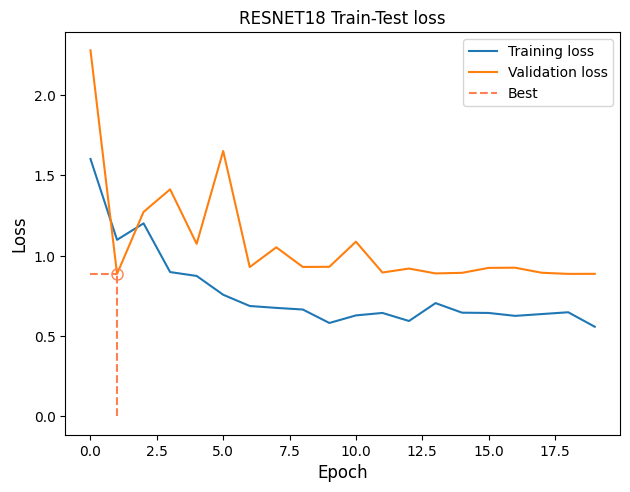

In [20]:
# Setting up, configuring, and training a RESNET18 model for the classification task.
print('-----------------------------------------------------------\n',
      '\t RESNET18',
      '\n----------------------------------------------------------')

# Initialize a pre-trained RESNET18 model.
model_ft = models.resnet18(pretrained=True)

# Freeze the model parameters to avoid updating them during training.
for param in model_ft.parameters():
    param.requires_grad = False

# Get the number of input features for the fully connected layer of the model.
num_ftrs = model_ft.fc.in_features
# Replace the fully connected layer with a new one tailored to the number of classes in our dataset.
model_ft.fc = nn.Linear(num_ftrs, number_classes)

# Transfer the model to the designated computing device.
model_ft = model_ft.to(device)

# Establish the loss function.
criterion = nn.CrossEntropyLoss()

# Configure the optimizer, opting for SGD with momentum.
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Set up a learning rate scheduler to reduce the learning rate by a factor of 0.1 every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Proceed to train the model using the defined settings and training function.
model_ft = train_model(model_ft, 'RESNET18', criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)


### >> ResNet50

 An extension of ResNet18, ResNet50 is deeper with 50 layers and employs the same residual connections strategy, allowing for more complex feature representations and improved accuracy in various vision tasks.

-----------------------------------------------------------
 	 RESNET50 
----------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should c

--------- Training in Cuda Mode ----------
Epoch 0/19
----------
Train Loss: 1.5242 Acc: 0.3633
Test Loss: 2.0497 Acc: 0.1837

Epoch 1/19
----------
Train Loss: 1.1289 Acc: 0.5467
Test Loss: 1.7543 Acc: 0.5918

Epoch 2/19
----------
Train Loss: 0.9718 Acc: 0.6350
Test Loss: 1.5030 Acc: 0.5510

Epoch 3/19
----------
Train Loss: 0.9870 Acc: 0.6233
Test Loss: 1.3703 Acc: 0.5918

Epoch 4/19
----------
Train Loss: 0.7915 Acc: 0.6950
Test Loss: 1.0032 Acc: 0.6122

Epoch 5/19
----------
Train Loss: 0.8800 Acc: 0.6600
Test Loss: 1.2855 Acc: 0.6531

Epoch 6/19
----------
Train Loss: 0.7234 Acc: 0.7250
Test Loss: 0.9704 Acc: 0.7347

Epoch 7/19
----------
Train Loss: 0.6406 Acc: 0.7533
Test Loss: 1.0162 Acc: 0.6735

Epoch 8/19
----------
Train Loss: 0.6721 Acc: 0.7250
Test Loss: 1.0575 Acc: 0.6735

Epoch 9/19
----------
Train Loss: 0.6621 Acc: 0.7433
Test Loss: 0.8944 Acc: 0.7347

Epoch 10/19
----------
Train Loss: 0.6636 Acc: 0.7517
Test Loss: 1.0093 Acc: 0.7347

Epoch 11/19
----------
Train Los

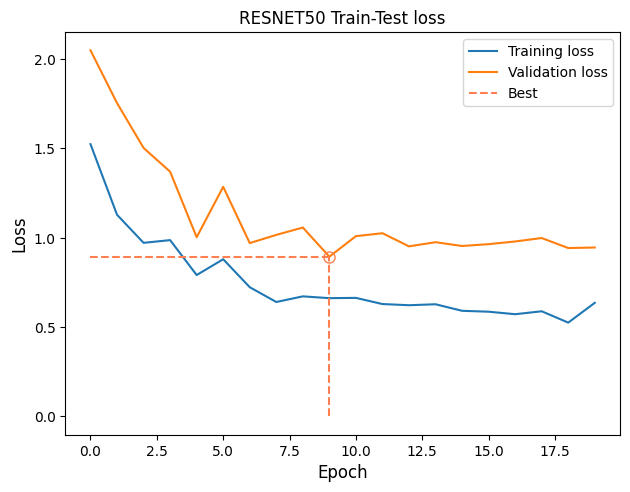

In [24]:
# Configuring and initiating the training process for a RESNET50 model for our classification task.
print('-----------------------------------------------------------\n',
      '\t RESNET50',
      '\n----------------------------------------------------------')

# Load a pre-trained RESNET50 model from PyTorch's model zoo.
model_rn50 = models.resnet50(pretrained=True)

# Freeze the model's parameters to prevent them from being updated during backpropagation.
for param in model_rn50.parameters():
    param.requires_grad = False

# Retrieve the number of input features to the model's fully connected layer.
num_ftrs = model_rn50.fc.in_features
# Replace the fully connected layer with one that matches the number of classes in our dataset.
model_rn50.fc = nn.Linear(num_ftrs, number_classes)

# Ensure the model operates on the correct device (GPU or CPU).
model_rn50 = model_rn50.to(device)

# Define the loss function to be used for training.
criterion = nn.CrossEntropyLoss()

# Setup the optimizer, choosing SGD with momentum for optimization.
optimizer_ft = optim.SGD(model_rn50.parameters(), lr=0.01, momentum=0.9)

# Implement a learning rate scheduler to decrease the learning rate by a factor of 0.1 every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Begin training the model with the specified configurations.
model_rn50 = train_model(model_rn50, 'RESNET50', criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)


### >> VGG16

VGG16 is characterized by its uniform architecture, using small 3x3 convolutional filters throughout, which demonstrated the effectiveness of depth in neural networks for enhancing image classification performance.

-----------------------------------------------------------
 	 VGG16BN 
----------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 96.0MB/s]


--------- Training in Cuda Mode ----------
Epoch 0/19
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Loss: 1.3088 Acc: 0.4533
Test Loss: 1.1938 Acc: 0.5306

Epoch 1/19
----------
Train Loss: 1.0218 Acc: 0.5967
Test Loss: 1.5631 Acc: 0.5102

Epoch 2/19
----------
Train Loss: 1.2152 Acc: 0.5617
Test Loss: 0.8764 Acc: 0.7143

Epoch 3/19
----------
Train Loss: 1.0308 Acc: 0.6400
Test Loss: 1.8680 Acc: 0.6531

Epoch 4/19
----------
Train Loss: 1.0610 Acc: 0.6267
Test Loss: 1.5185 Acc: 0.6531

Epoch 5/19
----------
Train Loss: 1.3555 Acc: 0.5617
Test Loss: 1.8634 Acc: 0.5306

Epoch 6/19
----------
Train Loss: 1.2248 Acc: 0.5883
Test Loss: 0.9454 Acc: 0.6939

Epoch 7/19
----------
Train Loss: 0.9321 Acc: 0.6617
Test Loss: 1.0164 Acc: 0.7143

Epoch 8/19
----------
Train Loss: 0.9854 Acc: 0.6250
Test Loss: 1.0557 Acc: 0.7143

Epoch 9/19
----------
Train Loss: 0.9058 Acc: 0.6683
Test Loss: 1.0737 Acc: 0.6939

Epoch 10/19
----------
Train Loss: 0.9172 Acc: 0.6567
Test Loss: 0.9498 Acc: 0.7143

Epoch 11/19
----------
Train Loss: 0.9572 Acc: 0.6467
Test Loss: 1.0697 Acc: 0.7143

Epoch 12/19


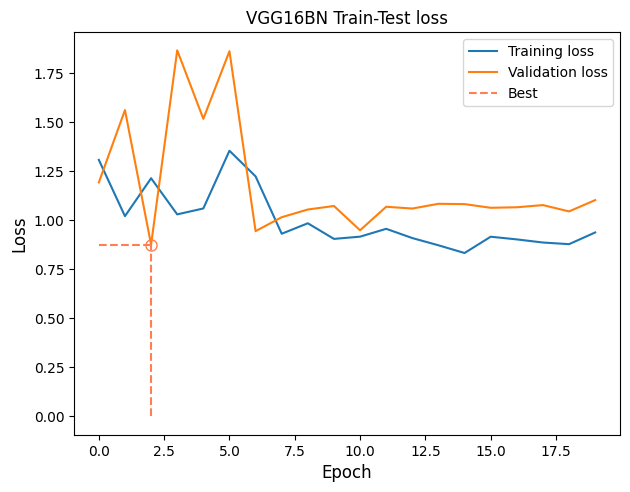

In [28]:
# Preparing and training a VGG16 model with Batch Normalization for our image classification task.
print('-----------------------------------------------------------\n',
      '\t VGG16BN',
      '\n----------------------------------------------------------')

# Load a pre-trained VGG16 model with batch normalization.
model_vgg = models.vgg16_bn(pretrained=True)

# Freeze all the parameters in the model to prevent them from being updated during the first phase of training.
for param in model_vgg.parameters():
    param.requires_grad = False

# Access the number of input features to the final layer of the classifier part of VGG16.
num_ftrs = model_vgg.classifier[6].in_features
# Replace the final layer of the classifier to match the number of classes in our dataset.
model_vgg.classifier[6] = nn.Linear(in_features=num_ftrs, out_features=number_classes)

# Transfer the model to the appropriate compute device.
model_vgg = model_vgg.to(device)

# Specify the loss function for the training process.
criterion = nn.CrossEntropyLoss()

# Set up the optimizer, here choosing SGD with momentum.
optimizer_ft = optim.SGD(model_vgg.parameters(), lr=0.01, momentum=0.9)

# Define a scheduler for learning rate adjustment; it reduces the learning rate by 0.1 every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Kick off the training process with the defined model and parameters.
model_vgg = train_model(model_vgg, 'VGG16BN', criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

### >> AlexNet

As one of the first deep convolutional neural networks to achieve significant success, AlexNet marked a milestone in deep learning by winning the ImageNet competition, showcasing the potential of deep learning in computer vision.

-----------------------------------------------------------
 	 ALEXNET 
----------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 149MB/s]


--------- Training in Cuda Mode ----------
Epoch 0/19
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Loss: 5.2837 Acc: 0.3917
Test Loss: 4.9208 Acc: 0.5918

Epoch 1/19
----------
Train Loss: 3.7422 Acc: 0.5300
Test Loss: 6.1971 Acc: 0.4898

Epoch 2/19
----------
Train Loss: 3.8069 Acc: 0.5883
Test Loss: 5.3356 Acc: 0.6122

Epoch 3/19
----------
Train Loss: 2.9177 Acc: 0.5700
Test Loss: 7.5777 Acc: 0.5714

Epoch 4/19
----------
Train Loss: 2.9743 Acc: 0.5867
Test Loss: 4.5344 Acc: 0.6531

Epoch 5/19
----------
Train Loss: 2.3321 Acc: 0.6433
Test Loss: 4.5778 Acc: 0.6735

Epoch 6/19
----------
Train Loss: 2.2522 Acc: 0.6467
Test Loss: 4.2613 Acc: 0.6122

Epoch 7/19
----------
Train Loss: 1.9574 Acc: 0.6950
Test Loss: 4.6943 Acc: 0.5918

Epoch 8/19
----------
Train Loss: 1.7890 Acc: 0.6650
Test Loss: 4.6649 Acc: 0.6122

Epoch 9/19
----------
Train Loss: 1.6264 Acc: 0.6883
Test Loss: 4.1739 Acc: 0.5918

Epoch 10/19
----------
Train Loss: 1.7350 Acc: 0.6500
Test Loss: 4.2126 Acc: 0.5918

Epoch 11/19
----------
Train Loss: 1.7998 Acc: 0.6600
Test Loss: 4.1206 Acc: 0.6122

Epoch 12/19


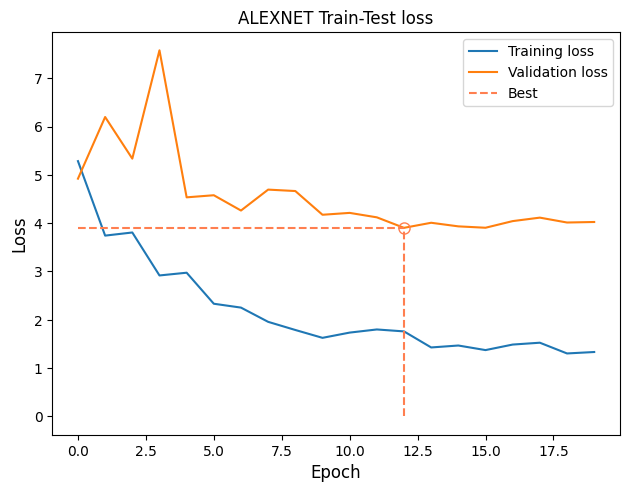

In [32]:
# Setting up and initiating the training of an ALEXNET model for our classification task.
print('-----------------------------------------------------------\n',
      '\t ALEXNET',
      '\n----------------------------------------------------------')

# Initializing a pre-trained ALEXNET model from the torchvision models.
model_an = models.alexnet(pretrained=True)

# Freezing the parameters of the model to prevent them from being updated during training.
for param in model_an.parameters():
    param.requires_grad = False

# Getting the number of input features to the last layer of the classifier part of ALEXNET.
num_ftrs = model_an.classifier[6].in_features
# Modifying the last layer of the classifier to match the number of classes in the dataset.
model_an.classifier[6] = nn.Linear(in_features=num_ftrs, out_features=number_classes)

# Ensuring the model is transferred to the designated compute device.
model_an = model_an.to(device)

# Defining the criterion for calculating loss during the training process.
criterion = nn.CrossEntropyLoss()

# Setting up the optimizer, choosing SGD with momentum for this purpose.
optimizer_ft = optim.SGD(model_an.parameters(), lr=0.01, momentum=0.9)

# Implementing a learning rate scheduler that reduces the learning rate by a factor of 0.1 every 7 epochs.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Commencing the model training with the specified configurations and training function.
model_an = train_model(model_an, 'ALEXNET', criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

<a id="evaluate"></a>
## Evaluate models

### >> DensNet121

Evaluating the trained model on the test dataset to assess its performance.

In [17]:
# Invoke the test_model function to evaluate the trained model using the test dataloader.
# This function returns the true labels and the predicted labels from the test set.
targets, preds = test_model(model_dn, dataloaders['Test'])

--------- Cuda Mode ----------
Predicting...

Testing completed in 0m 2s


Displaying the classification report to provide detailed metrics on the model's performance.

In [18]:
# Output a header for clarity in the results.
print("Classification Report")

# Generate and print the classification report, which includes precision, recall, f1-score, and support for each class.
print(classification_report(targets, preds))

Classification Report
              precision    recall  f1-score   support

         0.0       0.56      1.00      0.71         5
         1.0       0.45      1.00      0.62         5
         2.0       0.75      0.60      0.67         5
         3.0       0.67      0.29      0.40        14
         4.0       1.00      0.95      0.97        20

    accuracy                           0.73        49
   macro avg       0.69      0.77      0.68        49
weighted avg       0.78      0.73      0.72        49



Calculating and visualizing the confusion matrix to analyze the model's performance across different classes.

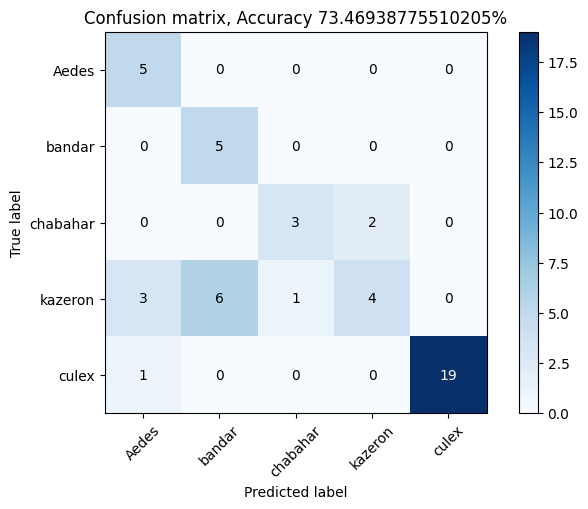

In [19]:
# Compute the confusion matrix based on the true labels and the model's predictions.
cnf_matrix = confusion_matrix(targets, preds)
# Set the numpy print options for precision to improve readability.
np.set_printoptions(precision=2)

# Retrieve the class names from the test dataset to label the confusion matrix.
class_names = image_datasets['Test'].classes
# Calculate the overall accuracy by comparing the true labels and predictions.
acc = accuracy_score(targets, preds)

# Invoke the previously defined function to plot the confusion matrix.
# The function displays the confusion matrix and annotates it with the class names.
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title=f'Confusion matrix, Accuracy {acc*100}%')

# Save the plotted confusion matrix to a file for later reference or reporting.
plt.savefig(f'conf_densenet.png')

### >> ResNet18

Evaluating the trained model on the test dataset to assess its performance.

In [21]:
# Invoke the test_model function to evaluate the trained model using the test dataloader.
# This function returns the true labels and the predicted labels from the test set.
targets, preds = test_model(model_ft, dataloaders['Test'])

--------- Cuda Mode ----------
Predicting...

Testing completed in 0m 2s


Displaying the classification report to provide detailed metrics on the model's performance.

In [22]:
# Output a header for clarity in the results.
print("Classification Report")

# Generate and print the classification report, which includes precision, recall, f1-score, and support for each class.
print(classification_report(targets, preds))

Classification Report
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83         5
         1.0       0.50      0.60      0.55         5
         2.0       0.45      1.00      0.62         5
         3.0       0.80      0.29      0.42        14
         4.0       1.00      1.00      1.00        20

    accuracy                           0.76        49
   macro avg       0.69      0.78      0.68        49
weighted avg       0.81      0.76      0.73        49



Calculating and visualizing the confusion matrix to analyze the model's performance across different classes.

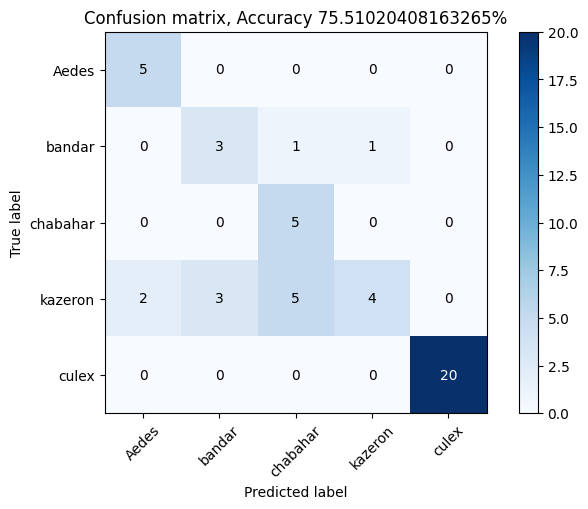

In [23]:
# Compute the confusion matrix based on the true labels and the model's predictions.
cnf_matrix = confusion_matrix(targets, preds)
# Set the numpy print options for precision to improve readability.
np.set_printoptions(precision=2)

# Retrieve the class names from the test dataset to label the confusion matrix.
class_names = image_datasets['Test'].classes
# Calculate the overall accuracy by comparing the true labels and predictions.
acc = accuracy_score(targets, preds)

# Invoke the previously defined function to plot the confusion matrix.
# The function displays the confusion matrix and annotates it with the class names.
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title=f'Confusion matrix, Accuracy {acc*100}%')

# Save the plotted confusion matrix to a file for later reference or reporting.
plt.savefig(f'conf_resnet18.png')

### >> ResNet50

Evaluating the trained model on the test dataset to assess its performance.

In [25]:
# Invoke the test_model function to evaluate the trained model using the test dataloader.
# This function returns the true labels and the predicted labels from the test set.
targets, preds = test_model(model_rn50, dataloaders['Test'])

--------- Cuda Mode ----------
Predicting...

Testing completed in 0m 2s


Displaying the classification report to provide detailed metrics on the model's performance.

In [26]:
# Output a header for clarity in the results.
print("Classification Report")

# Generate and print the classification report, which includes precision, recall, f1-score, and support for each class.
print(classification_report(targets, preds))

Classification Report
              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62         5
         1.0       0.56      1.00      0.71         5
         2.0       1.00      0.80      0.89         5
         3.0       1.00      0.21      0.35        14
         4.0       0.91      1.00      0.95        20

    accuracy                           0.76        49
   macro avg       0.78      0.80      0.71        49
weighted avg       0.86      0.76      0.72        49



Calculating and visualizing the confusion matrix to analyze the model's performance across different classes.

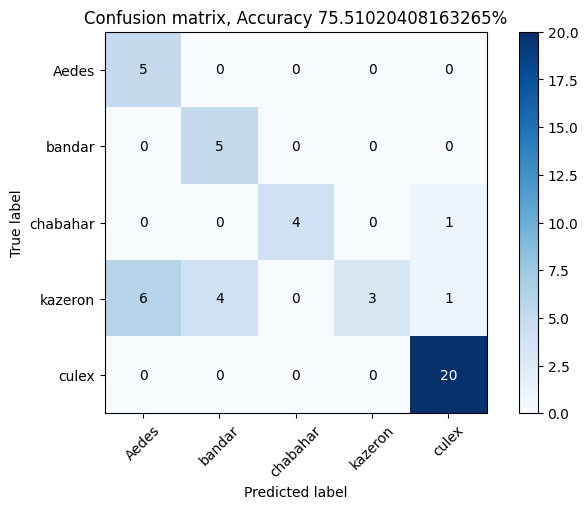

In [27]:
# Compute the confusion matrix based on the true labels and the model's predictions.
cnf_matrix = confusion_matrix(targets, preds)
# Set the numpy print options for precision to improve readability.
np.set_printoptions(precision=2)

# Retrieve the class names from the test dataset to label the confusion matrix.
class_names = image_datasets['Test'].classes
# Calculate the overall accuracy by comparing the true labels and predictions.
acc = accuracy_score(targets, preds)

# Invoke the previously defined function to plot the confusion matrix.
# The function displays the confusion matrix and annotates it with the class names.
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title=f'Confusion matrix, Accuracy {acc*100}%')

# Save the plotted confusion matrix to a file for later reference or reporting.
plt.savefig(f'conf_resnet50.png')

### >> VGG16

Evaluating the trained model on the test dataset to assess its performance.

In [29]:
# Invoke the test_model function to evaluate the trained model using the test dataloader.
# This function returns the true labels and the predicted labels from the test set.
targets, preds = test_model(model_vgg, dataloaders['Test'])

--------- Cuda Mode ----------
Predicting...

Testing completed in 0m 3s


Displaying the classification report to provide detailed metrics on the model's performance.

In [30]:
# Output a header for clarity in the results.
print("Classification Report")

# Generate and print the classification report, which includes precision, recall, f1-score, and support for each class.
print(classification_report(targets, preds))

Classification Report
              precision    recall  f1-score   support

         0.0       0.67      0.80      0.73         5
         1.0       0.45      1.00      0.62         5
         2.0       0.56      1.00      0.71         5
         3.0       1.00      0.14      0.25        14
         4.0       0.95      1.00      0.98        20

    accuracy                           0.73        49
   macro avg       0.73      0.79      0.66        49
weighted avg       0.85      0.73      0.68        49



Calculating and visualizing the confusion matrix to analyze the model's performance across different classes.

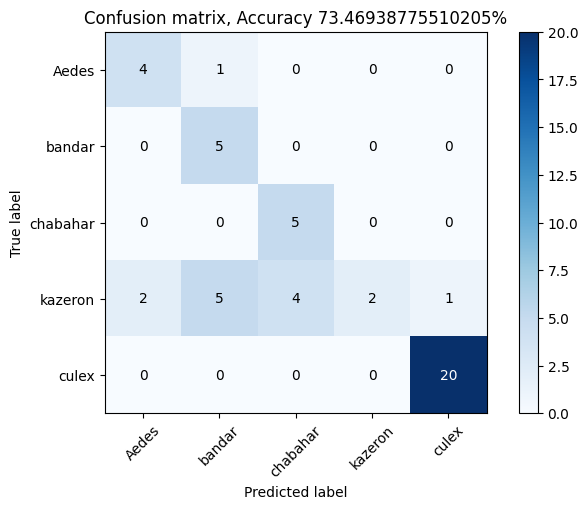

In [31]:
# Compute the confusion matrix based on the true labels and the model's predictions.
cnf_matrix = confusion_matrix(targets, preds)
# Set the numpy print options for precision to improve readability.
np.set_printoptions(precision=2)

# Retrieve the class names from the test dataset to label the confusion matrix.
class_names = image_datasets['Test'].classes
# Calculate the overall accuracy by comparing the true labels and predictions.
acc = accuracy_score(targets, preds)

# Invoke the previously defined function to plot the confusion matrix.
# The function displays the confusion matrix and annotates it with the class names.
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title=f'Confusion matrix, Accuracy {acc*100}%')

# Save the plotted confusion matrix to a file for later reference or reporting.
plt.savefig(f'conf_vgg16.png')

### >> AlexNet

Evaluating the trained model on the test dataset to assess its performance.

In [33]:
# Invoke the test_model function to evaluate the trained model using the test dataloader.
# This function returns the true labels and the predicted labels from the test set.
targets, preds = test_model(model_an, dataloaders['Test'])

--------- Cuda Mode ----------
Predicting...

Testing completed in 0m 2s


Displaying the classification report to provide detailed metrics on the model's performance.

In [34]:
# Output a header for clarity in the results.
print("Classification Report")

# Generate and print the classification report, which includes precision, recall, f1-score, and support for each class.
print(classification_report(targets, preds))

Classification Report
              precision    recall  f1-score   support

         0.0       0.38      1.00      0.56         5
         1.0       0.33      0.20      0.25         5
         2.0       0.67      0.80      0.73         5
         3.0       0.86      0.43      0.57        14
         4.0       0.85      0.85      0.85        20

    accuracy                           0.67        49
   macro avg       0.62      0.66      0.59        49
weighted avg       0.73      0.67      0.67        49



Calculating and visualizing the confusion matrix to analyze the model's performance across different classes.

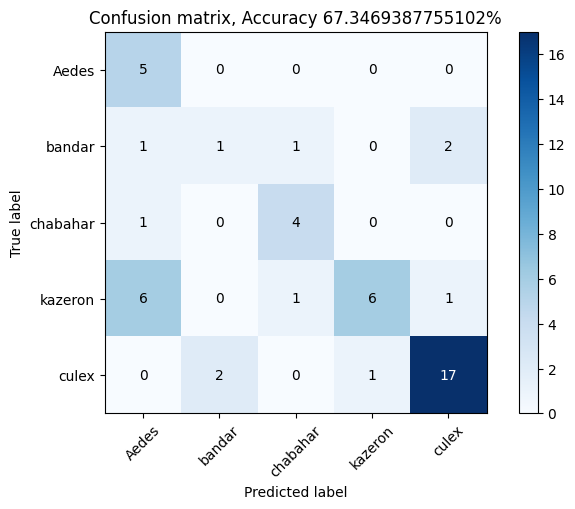

In [35]:
# Compute the confusion matrix based on the true labels and the model's predictions.
cnf_matrix = confusion_matrix(targets, preds)
# Set the numpy print options for precision to improve readability.
np.set_printoptions(precision=2)

# Retrieve the class names from the test dataset to label the confusion matrix.
class_names = image_datasets['Test'].classes
# Calculate the overall accuracy by comparing the true labels and predictions.
acc = accuracy_score(targets, preds)

# Invoke the previously defined function to plot the confusion matrix.
# The function displays the confusion matrix and annotates it with the class names.
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title=f'Confusion matrix, Accuracy {acc*100}%')

# Save the plotted confusion matrix to a file for later reference or reporting.
plt.savefig(f'conf_alexnet.png')

### >> Misclassifications

Displaying a subset of misclassified images from the test set to help diagnose and understand model errors.

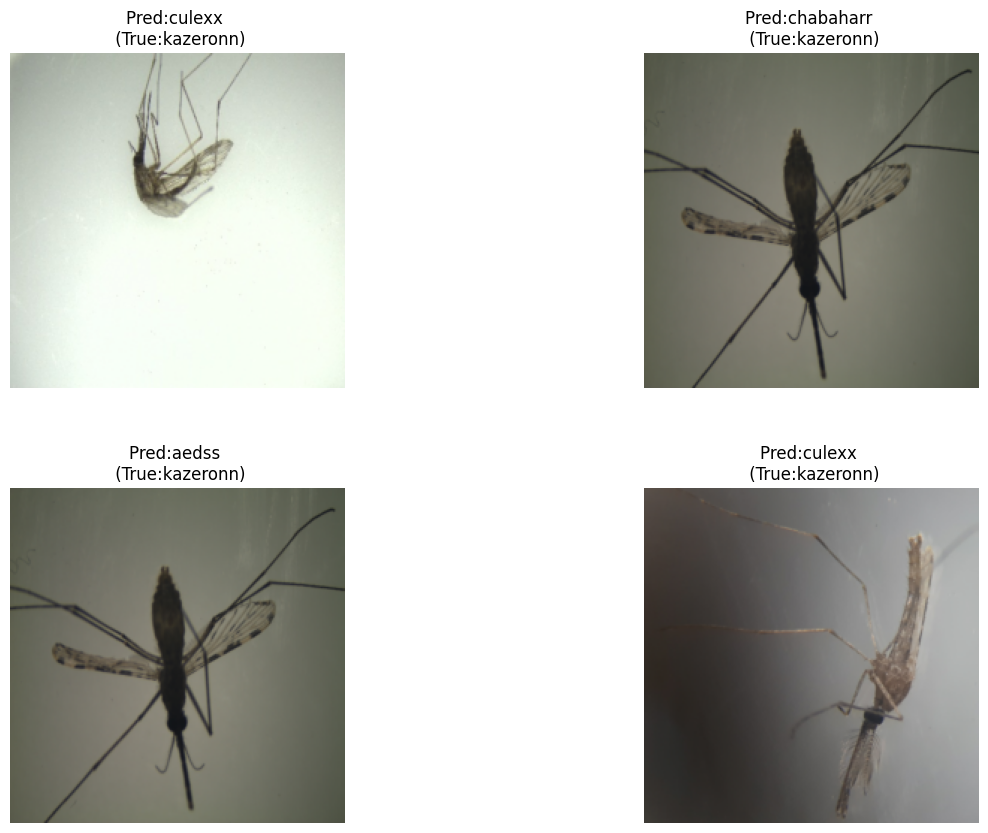

In [ ]:
# The show_misclass function is called with the trained model and the test dataloader.
# It is configured to display a 2x2 grid of misclassified images.
show_misclass(model_ft, dataloaders['Test'], 2, 2)

<a id="evaluate"></a>
## Grad-CAM

Import necessary libraries


In [36]:
import os
import PIL
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

### >> Heatmap Overlay for Model Attention Visualization


This function creates and overlays a heatmap on an image based on a given attention mask, illustrating the regions that a model focuses on. It's useful for interpreting model decisions by visually highlighting significant areas in the image, enhancing understanding of model behavior.

In [37]:
# Applies a heatmap to a given mask over an image. The heatmap is a visual representation of areas of interest in the image, highlighting where the model focuses its attention.
def visualize_cam(mask, img):
    # Convert mask to a heatmap.
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    # Split and merge the heatmap channels.
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    # Overlay the heatmap onto the original image.
    result = heatmap + img.cpu()
    result = result.div(result.max()).squeeze()
    return heatmap, result

### >> Layer-Specific Accessor for Architectures

These functions provide a streamlined approach to pinpoint and access specific layers within popular convolutional neural network architectures like ResNet, DenseNet, and VGG. They are essential for tasks that require direct interaction with individual layers, such as feature extraction, applying Grad-CAM, or custom layer modifications for enhanced model interpretability and performance tuning.

In [38]:
# Locates a specific layer in a ResNet architecture. This is useful for models that require layer-specific operations, such as feature extraction or applying Grad-CAM.
def find_resnet_layer(arch, target_layer_name):
    # Parse the layer name and navigate the ResNet architecture.
    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        # Access the main layer (layer1, layer2, etc.).
        target_layer = getattr(arch, f'layer{layer_num}')
        # Navigate through bottlenecks or basic blocks if specified.
        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]
        # Further navigate through internal modules if necessary.
        for h in hierarchy[2:]:
            target_layer = target_layer._modules[h]
    else:
        target_layer = arch._modules[target_layer_name]
    return target_layer

In [39]:
# Identifies a specific layer within a DenseNet architecture, facilitating operations like feature extraction or layer-specific modifications.
def find_densenet_layer(arch, target_layer_name):
    # Navigate the DenseNet architecture by parsing the target layer name.
    hierarchy = target_layer_name.split('_')
    target_layer = arch
    for h in hierarchy:
        target_layer = target_layer._modules[h]
    return target_layer

In [40]:
# Finds a specific layer in a VGG model. This is particularly useful for feature extraction, applying modifications, or visualization techniques such as CAM.
def find_vgg_layer(arch, target_layer_name):
    # VGG architectures are linear in features, making it straightforward to access layers.
    hierarchy = target_layer_name.split('_')
    target_layer = arch.features if 'features' in hierarchy[0] else arch
    if len(hierarchy) > 1:
        target_layer = target_layer[int(hierarchy[1])]
    return target_layer

In [41]:
# Locates a specific layer within an AlexNet architecture, aiding in operations that require accessing individual layers, such as feature extraction or visualization.
def find_alexnet_layer(arch, target_layer_name):
    # AlexNet layer access follows a similar pattern to VGG with a linear sequence in 'features'.
    hierarchy = target_layer_name.split('_')
    target_layer = arch.features if 'features' in hierarchy[0] else arch
    if len(hierarchy) > 1:
        target_layer = target_layer[int(hierarchy[1])]
    return target_layer

### >> Normalization and Denormalization

These utilities offer functions and a class for normalizing and denormalizing image tensors with specified means and standard deviations, facilitating the preparation of images for neural network processing and the restoration of processed images to their original form for visualization and interpretation.

In [42]:
# Denormalizes a tensor using the provided mean and standard deviation, reversing the normalization process.
def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')
    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    return tensor.mul(std).add(mean)

In [43]:
# Normalizes a tensor using the provided mean and standard deviation.
def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')
    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    return tensor.sub(mean).div(std)

In [44]:
# A normalization utility class that can be used to normalize and denormalize image tensors using specified mean and standard deviation.
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """Normalizes a tensor."""
        return self.do(tensor)

    def do(self, tensor):
        """Normalizes a tensor."""
        return normalize(tensor, self.mean, self.std)

    def undo(self, tensor):
        """Denormalizes a tensor."""
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


### >> GradCAM & GradCAM++

In [45]:
# Calculate GradCAM saliency map.
class GradCAM(object):
    """
    Args:
        model_dict (dict): a dictionary containing 'model_type', 'arch', 'layer_name', and 'input_size' (optional).
        verbose (bool): whether to print output size of the saliency map given 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        self.model_arch = model_dict['arch']

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        if 'vgg' in model_type.lower():
            target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
            target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            target_layer = find_densenet_layer(self.model_arch, layer_name)
        elif 'alexnet' in model_type.lower():
            target_layer = find_alexnet_layer(self.model_arch, layer_name)

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        if verbose:
            try:
                input_size = model_dict['input_size']
            except KeyError:
                print("Please specify the size of the input image in model_dict. e.g. {'input_size':(224, 224)}")
            else:
                device = 'cuda' if next(self.model_arch.parameters()).is_cuda else 'cpu'
                self.model_arch(torch.zeros(1, 3, *(input_size), device=device))
                print('Saliency map size:', self.activations['value'].shape[2:])


    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that produces the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension as input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

In [46]:
# Calculate GradCAM++ saliency map.
class GradCAMpp(GradCAM):
    """
    Args:
        model_dict (dict): a dictionary containing 'model_type', 'arch', 'layer_name', and 'input_size' (optional).
        verbose (bool): whether to print output size of the saliency map given 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        super(GradCAMpp, self).__init__(model_dict, verbose)

    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that produces the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension as input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
                activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom+1e-7)
        positive_gradients = F.relu(score.exp()*gradients) # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
        weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

        return saliency_map, logit

In [47]:
# Define the image path
image_path = '/content/drive/MyDrive/mosquito-classification/Test/kazeron/20190724_132306_hf.jpg'

# Open the image using PIL
pil_img = PIL.Image.open(image_path)

# Resize the image to (224,224)
pil_img.resize((224,224))

# Normalize the image
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Convert PIL image to torch tensor
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()

# Upsample the tensor to (224, 224)
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)

# Apply normalization
normed_torch_img = normalizer(torch_img)

<ipython-input-47-a76ca0885f57>:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [53]:
# Define the path where the models are stored
models_path = '/content/'

# List of model names
models_name = ['densenet121', 'resnet18', 'resnet50', 'vgg16', 'alexnet']

# Number of output features
out_features = 5

### >> Initializing GradCAM and GradCAM++

This code sets up GradCAM and GradCAM++ visualizations for various CNN models including ResNet18, ResNet50, DenseNet121, VGG16, and AlexNet. It prepares a dictionary to store GradCAM objects for each model, specifying the architecture, target layer, and input size, facilitating the interpretation of model decisions through visual heatmaps.

In [54]:
# Create a dictionary to store GradCAM and GradCAM++ objects for each model
cam_dict = {}

# Iterate over each model name
for model_name in models_name:
    if (model_name == 'resnet18'):
        # Initialize ResNet18 model
        model_ft = models.resnet18(pretrained=True)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features=num_ftrs, out_features=out_features)
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('resnet18 the model loaded....')
        model_ft.eval(), model_ft.cuda();
        resnet_model_dict = dict(type='resnet18', arch=model_ft, layer_name='layer4', input_size=(224, 224))
        resnet_gradcam = GradCAM(resnet_model_dict, True)
        resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
        cam_dict['resnet18'] = [resnet_gradcam, resnet_gradcampp]

    elif (model_name == 'resnet50'):
        # Initialize ResNet50 model
        model_ft = models.resnet50(pretrained=True)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(in_features=num_ftrs, out_features=out_features)
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('resnet50 the model loaded....')
        model_ft.eval(), model_ft.cuda();
        resnet_model_dict = dict(type='resnet50', arch=model_ft, layer_name='layer4', input_size=(224, 224))
        resnet_gradcam = GradCAM(resnet_model_dict, True)
        resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
        cam_dict['resnet50'] = [resnet_gradcam, resnet_gradcampp]

    elif (model_name == 'densenet121'):
        # Initialize DenseNet121 model
        model_ft = models.densenet121(pretrained=True)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(in_features=num_ftrs, out_features=out_features)
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('densenet121 the model loaded....')
        model_ft.eval(), model_ft.cuda();
        densenet_model_dict = dict(type='densenet', arch=model_ft, layer_name='features_denseblock3', input_size=(224, 224))
        densenet_gradcam = GradCAM(densenet_model_dict, True)
        densenet_gradcampp = GradCAMpp(densenet_model_dict, True)
        cam_dict['densenet'] = [densenet_gradcam, densenet_gradcampp]

    elif (model_name == 'vgg16'):
        # Initialize VGG16_bn model
        model_ft = models.vgg16_bn(pretrained=True)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(in_features=num_ftrs ,out_features=out_features )
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('vgg16bn the model loaded....')
        model_ft.eval(), model_ft.cuda();
        vgg_model_dict = dict(type='vgg', arch=model_ft, layer_name='features_29', input_size=(224, 224))
        vgg_gradcam = GradCAM(vgg_model_dict, True)
        vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
        cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

    elif (model_name == 'alexnet'):
        # Initialize AlexNet model
        model_ft = models.alexnet(pretrained=True)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(in_features=num_ftrs ,out_features=out_features )
        if model_name+'.pth' in os.listdir(models_path):
            state_dict = torch.load(os.path.join(models_path, model_name+'.pth'))
            model_ft.load_state_dict(state_dict)
            print('alexnet the model loaded....')
        model_ft.eval(), model_ft.cuda();
        alexnet_model_dict = dict(type='alexnet', arch=model_ft, layer_name='features_11', input_size=(224, 224))
        alexnet_gradcam = GradCAM(alexnet_model_dict, True)
        alexnet_gradcampp = GradCAMpp(alexnet_model_dict, True)
        cam_dict['alexnet'] = [alexnet_gradcam, alexnet_gradcampp]


Saliency map size: torch.Size([14, 14])
Saliency map size: torch.Size([14, 14])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saliency map size: torch.Size([7, 7])
Saliency map size: torch.Size([7, 7])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saliency map size: torch.Size([7, 7])
Saliency map size: torch.Size([7, 7])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saliency map size: torch.Size([28, 28])
Saliency map size: torch.Size([28, 28])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saliency map size: torch.Size([13, 13])
Saliency map size: torch.Size([13, 13])


### >> Generating and Storing GradCAM Visualizations


This iterates through GradCAM and GradCAM++ objects, generating saliency maps to highlight model focus areas on images. It visualizes these maps, combines them with the original image, and appends them to a list. The images are then arranged into a grid and saved, showcasing the comparative insights provided by GradCAM and GradCAM++ side by side.

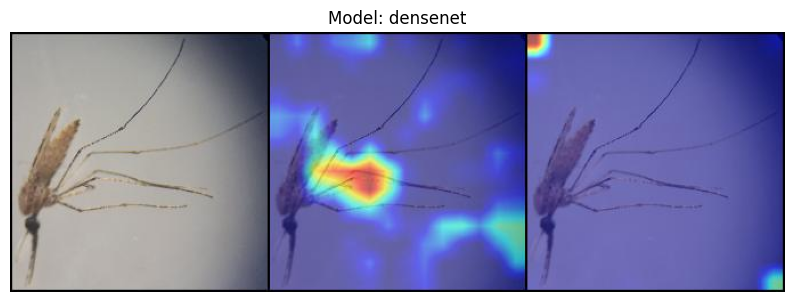

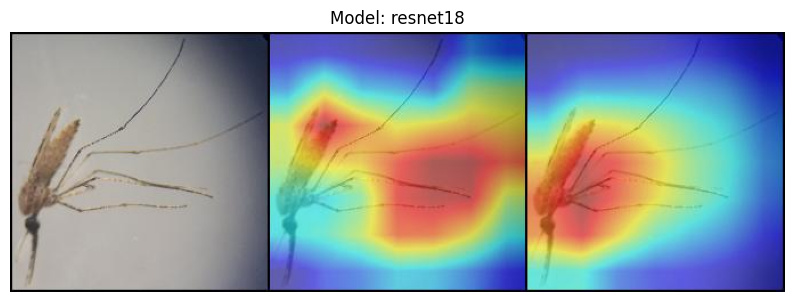

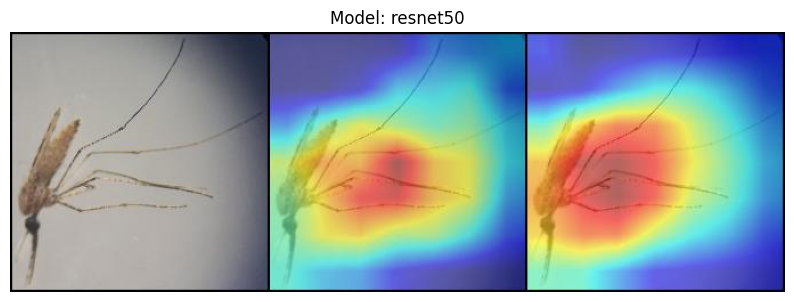

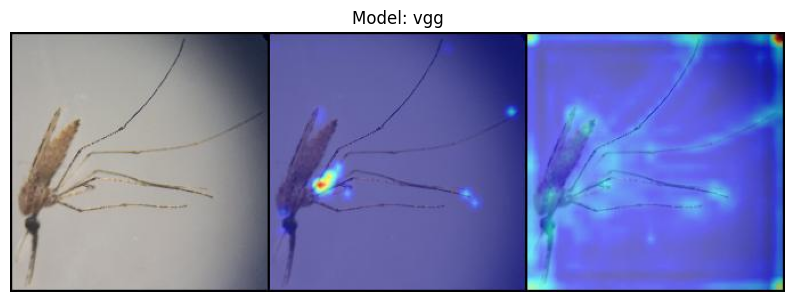

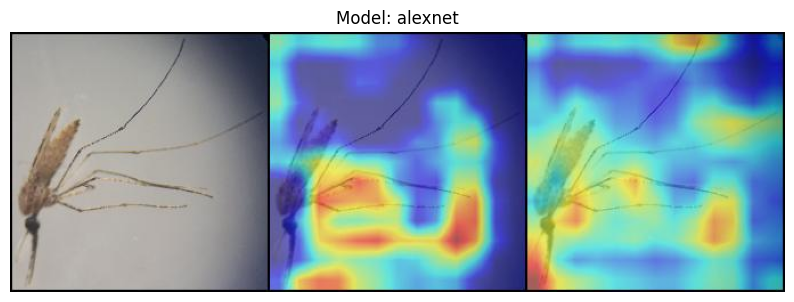

In [60]:
import matplotlib.pyplot as plt
import PIL.Image

# List to hold visualizations
images = []

# Generate and store GradCAM and GradCAM++ visualizations
for model_name, (gradcam, gradcam_pp) in cam_dict.items():
    # GradCAM visualization
    mask, _ = gradcam(normed_torch_img)
    _, result = visualize_cam(mask.cpu(), torch_img.cpu())

    # GradCAM++ visualization
    mask_pp, _ = gradcam_pp(normed_torch_img)
    _, result_pp = visualize_cam(mask_pp.cpu(), torch_img.cpu())

    # Append visualizations to the list
    images.append(torch.stack([torch_img.squeeze().cpu(), result, result_pp], 0))

    # Arrange images in a grid
    images_grid = make_grid(torch.cat(images, 0), nrow=5)

    # Define the output filename with the model name
    output_filename = f'test_{model_name}.jpg'

    # Save the image grid
    output_path = os.path.join('/content', output_filename)
    save_image(images_grid, output_path)

    # Clear the images list for the next model
    images = []

    # Open and display the saved image using PIL
    display_img = PIL.Image.open(output_path)

    # Display the image with the model name as the title
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.imshow(display_img)
    plt.title(f"Model: {model_name}")  # Set the title to include the model name
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the plot

<a id="conclusion"></a>
## Conslusion

In conslusion, we've seen that even with just a small dataset, our deep learning models—especially ResNet18 and ResNet50—did a great job at classifying mosquito species. They were quick learners and gave us accurate results, which makes them pretty handy for scientists who need fast and trustworthy tools for identifying bugs. On the other hand, older models like VGG16 and AlexNet weren't as quick or sharp in this test, reminding us that newer models can be better choices when working with not a lot of data.

The utilization of Grad-CAM within this research provided an insightful window into the decision-making processes of our models. The technique revealed that the models were not arbitrarily classifying images but were instead focusing on definitive morphological features of the mosquitoes, such as the thorax and wing structure, which are critical for accurate species identification. This level of interpretability instills a layer of trust in the models' outputs, confirming that the models are methodically analyzing relevant characteristics.

The implications of this research are profound. The deep learning models employed have proven adept at facilitating critical tasks such as species classification, and they have achieved this with a limited dataset—an accomplishment that cannot be overstated. This paves the way for the application of artificial intelligence in specialized research fields that often grapple with data scarcity. The findings affirm that artificial intelligence can be a transformative asset in such disciplines, enhancing research efficiency and efficacy.

